# Working with GeoPandas and PySAL

We've worked -- and will continue to work -- a lot with pandas, but by default pandas doesn't help us much when want to start working with explicitly geographical data. Ways of working _computationally_ with things like distance and location are increasingly important not only to geographers, but also to data scientists, and this is where we start to move away from purely aspatial statistical analysis into the foundations of a more _geographic_ data science.

There are a huge number of modules in Python designed to help you work with geodata, but we are going to focus on the two most important higher-level libraries (since they also provide 'wrappers' around some of the lower-level libraries):

1. [GeoPandas](http://geopandas.org/) -- which offers a pandas-like interface to working with geodata. Think of this as your tool for basic data manipulation and transformation, much like pandas. You will almost certainly want to [bookmark the documentation](http://geopandas.org/user.html#geodataframe).
2. [PySAL](http://pysal.readthedocs.io/en/latest/) -- the Python Spatial Analysis Library  provides the spatial analytic functions that we'll need for everything from classification, clustering and point-pattern analysis to autocorrelation-based tools.
3. There is some overlap between the two libraries: both can do plotting but, for reasons we'll see later, we'll normally do this in PySAL and both can do classification (remember, we did _quantiles_ with pandas!) but (again), for reasons we'll see later, we'll often do this in PySAL from here on out.

PySAL is complicated enough that the best way to understand how it fits together is to use an image:

![PySAL Logo](http://darribas.org/gds_scipy16/content/figs/pysal.png)

We're going to concentrate primarily on the ESDA (Exploratory _Spatial_ Data Analysis) and Weights components of PySAL in this module, but you should know about the other bits!

## A (Semi-Brief) Discourse on Families & Inheritance

GeoPandas objects are deliberately designed to resemble Pandas objects. There are two good reasons for this: 

1. Since Pandas is well-known, this makes it easier to learn how to use GeoPandas.
2. GeoPandas _inherits_ functionality from Pandas. 

The concept of **inheritance** is something we've held off from mentioning until now, but it's definitely worth understanding if you are serious about learning how to code. In effect, geopandas '_imports_' pandas and then _extends_ it so that the more basic class (pandas in this case) learns how to work with geodata... pandas doesn't know how to read shapefiles or make maps, but geopandas does. Same for GeoJSON.

### The 'Tree of Life'

Here's a simple way to think about inheritance: think of the 'evolutionary trees' you might have seen charting the evolution of organisms over time. At the bottom of the tree is the single-celled animal, and at the other end are humans, whales, wildebeest, etc. We all _inherit_ some basic functionality from that original, simple cell. In between us and that primitive, however, are a whole series of branches: different bits of the tree evolved in different directions and developed different 'functionality'. Some of us have bones. Some have  cartilege. Some are vegetarian, and some are carnivorous. And so on. When you get to the primates we all share certain common 'features' (binocular vision, grasping hands, etc.), but we are _still_ more similar to gorillas than we are to macaques. So gorillas and humans _extend_ the primitive 'primate functionality' with some bonus features (bigger brains, greater strength, etc.) that are useful, while macaques extend it with a slightly different set of features (tails, etc.).

![Tree of Life](http://palaeos.com/systematics/tree/images/treeolif.jpg)

### The 'Tree of Classes'

Inheritance in code works in a similar way: *all* Python classes (lists, pandas, plots, etc.) inherit their most basic functionality from a single primitive 'object' class that itself does very little except to provide a template for what an object should look like. As you move along the inheritance tree you will find more and more complex objects with increasingly advanced features: GeoPandas inherits from Pandas, Bokeh and Seaborn inherit from matplotlib, etc. 

I can't find an image of Python base class inheritance, but I've found an equally useful example of how _anything_ can be modelled using this 'family tree' approach... consider the following:

![Vehicle Inheritance](http://www.mkonar.org/dogus/wiki/lib/exe/fetch.php/python/vehicle.png?w=750&tok=4c7ed7)

If we were trying to implement a vehicle registration scheme in Python, we would want to start with the most basic category of all: _vehicle_. The vehicle class itself might not do much, but it gives us a template for _all_ vehicles (e.g. it must be registered, it must have a unique license number, etc.). We then _extend_ the functionality of this 'base class' with three intermediate classes: two-wheeled vehicles, cars, and trucks. These, in turn, lead to eight actual vehicle types. These might have _additional_ functionality: a bus might need have a passenger capacity associated with it, while a covnertible might need to be hard- or soft-top. All of this could be expressed in Python as:

```python
class vehicle(object): # Inherit from base class
    def __init__(self):
        ... do something ...

class car(vehicle): # Inherit from vehicle
    def __init__(self):
        ... do other stuff ...

class sedan(car): # Inherit from car
    def __init__(self):
        ... do more stuff ...
```

This way, when we create a new `sedan`, it automatically 'knows' about vehicles and cars, and can make use of functions like `set_unique_id(<identification>)` even if that function is _only_ specified in the base vehicle class! The thing to remember is that programmers are _lazy_: if they can avoid reinventing the wheel, they will. Object-Oriented Programming using inheritance is a good example of _constructive_ laziness: it saves us having to constantly copy and paste code (for registering a new vehicle or reading in a CSV file) from one class to the next since we can just import it and extent it! 

Inheritance also means that you can always use an instance of a 'more evolved' class in place of one of its ancestors: simplifying things a _bit_, a sedan can automatically do anything that a car can do and, by extension, anything that a vehicle can do. Similarly, since geopandas inherits from pandas if you need to use a geopandas object _as if_ it's a pandas object then that will work! So everything you learned last term for pandas can still be used in geopandas. Kind of cool, right?

Finally, looking back at our example above: what about unicycles? Or tracked vehicles like a tank? This is where _design_ comes into the picture: when we're planning out a family tree for our work we need to be careful about what goes where. And there isn't always a single right answer: perhaps we should distinguish between pedal-powered and motor-powered (in which case unicycles, bicycles and tricycles all belong in the same family)? Or perhaps we need to distinguish between wheeled and tracked (in which case we're missing a pair of classes [wheeled, tracked] between 'vehicle' and 'two-wheel, car, truck')? These choices are tremendously important but often very hard to get right.

OK, that's enough programming theory, let's see this in action...

## Getting the Data

Two of the data sets that we want this week are downloadable for free:

1. Grab the 'simple' world shapefile from [ThematicMapping.org](http://thematicmapping.org/downloads/world_borders.php) and save it into a directory called 'shapes' in your notebook directory **_before_ unzipping it_**.

2. The London AirBnB _listings_ from [InsideAirBnB](http://insideairbnb.com/get-the-data.html) which you will save into a directory called 'data' in your notebook directory and **_do not_ unzip it**.

3. The third data set is one that you can download from [here](http://www.reades.com/LDN-LSOAs.zip) and you will save it into a directory called 'shapes' in your notebook directory **_before_ unzipping it**.

That _should_ cover it.

## Reading a Shapefile with GeoPandas

Similar to what we did last week, I want you to start by creating a map of the world coloured according to population. But this week we're going to do it in GeoPandas instead of Folium.

First, you will need to download the zipped World Borders shapefile from [Thematic Mapping](http://thematicmapping.org/downloads/TM_WORLD_BORDERS_SIMPL-0.3.zip) and save this to your 'shapes' or 'data' folder since GeoPandas can't read 'remote' files. You will also need to unzip the file so that Geopandas can read it.

_Remember:_ as long as you have saved the file to somewhere accessible to Jupyter (i.e. a directory _beneath_ the current one where you are working) then you can find out the 'path' to a file by switching to the 'Home' tab in your browser and navigating to the file. You can _also_ find out where the current Notebook is running like this:

In [ ]:
!pwd # !cd on Windows

In other words, depending on your setup you might need to tweak the path in the code below to get your own code working...

In [3]:
import os
import pandas as pd
import geopandas as gpd

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

# Make sure output is into notebook
%matplotlib inline

In [4]:
gdf = gpd.read_file( 
    os.path.join('shapes', 'TM_WORLD_BORDERS_SIMPL-0.3', 'TM_WORLD_BORDERS_SIMPL-0.3.shp') 
)

gdf.head(3)

,AREA,FIPS,ISO2,ISO3,LAT,LON,NAME,POP2005,REGION,SUBREGION,UN,geometry
0,44,AC,AG,ATG,17,-62,Antigua and Barbuda,83039,19,29,28,(POLYGON ((-61.68666800000003 17.0244410000001...
1,238174,AG,DZ,DZA,28,3,Algeria,32854159,2,15,12,"POLYGON ((2.963610000000017 36.802216, 4.78583..."
2,8260,AJ,AZ,AZE,40,47,Azerbaijan,8352021,142,145,31,(POLYGON ((45.08332252502441 39.76804542541504...


So far so good! Notice that even the output of the `head` function is the same as from pandas. The only obvious difference so far is that `geometry` column on the right-hand side which doesn't contain numbers or strings, but `POLYGON`s. In a nutshell, aside from the ability to read geodata directly (we just loaded a shapefile using only code!) this geometry column is the other marker of a big step from pandas to geopandas.

But let's dig a little deeper:

In [5]:
print("Let's look at inheritance: ")

if isinstance(gdf, gpd.GeoDataFrame): # Is gdf a GeoDataFrame object?
    print("\tI'm a geopandas data frame!")

if isinstance(gdf, pd.DataFrame): # Is gdf *also* a DataFrame object?
    print("\tI'm also a pandas data frame!")

print("-" * 50)

print("Let's look at some pandas methods we know: ") # See inheritance in action

print("Using the 'sample()' method: ")
print(gdf.sample(3))
print("-" * 50)

print("What the POP2005 column type: ")
print('\tNAME type: ' + str(type(gdf.POP2005)))
print("-" * 50)

print("Describe the column: ")
print(gdf.POP2005.describe())
print("-" * 50)

print("Let's look at some new methods from geopandas: ") # Here's stuff pandas can't do

print("What's the geometry column type: ")
print('\tGeometry type: ' + str(type(gdf.geometry)))
print("-" * 50)

# The next line is very slow, don't run it:
# print(gdf.geometry.describe())
# print("-" * 50)

print("Is there projection information: ")
print('\tCRS: ' + str(gdf.crs))
print("-" * 50)

print("Help with the centroid method of the GeoSeries (geometry) column: ")
help(gdf.geometry.centroid)

Let's look at inheritance: 
	I'm a geopandas data frame!
	I'm also a pandas data frame!
--------------------------------------------------
Let's look at some pandas methods we know: 
Using the 'sample()' method: 
      AREA FIPS ISO2 ISO3  LAT  LON                    NAME   POP2005  REGION  \
91   56914   KE   KE  KEN    1   38                   Kenya  35598952       2   
194  51089   TH   TH  THA   16  101                Thailand  63002911     142   
15    5120   BK   BA  BIH   44   18  Bosnia and Herzegovina   3915238     150   

     SUBREGION   UN                                           geometry  
91          14  404  (POLYGON ((41.13805400000015 -2.12444399999991...  
194         35  764  (POLYGON ((99.21916200000007 6.532499000000001...  
15          39   70  POLYGON ((17.64984100000007 42.88907600000009,...  
--------------------------------------------------
What the POP2005 column type: 
	NAME type: <class 'pandas.core.series.Series'>
----------------------------------------

This next command may take a while to complete -- the geopandas developers know that their mapping code is sloooooooooow, and that's one of the reasons we're going to use PySAL for most of our work. But 'watch this space' since they are working on it and there may even be an update this year that addresses the single biggest complaint that people have about geopandas.

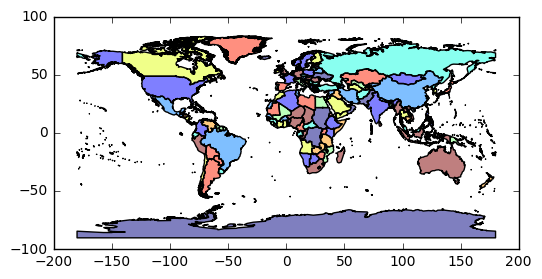

In [6]:
gdf.plot()

Some questions for you:
1. What type of data structure is the CRS attribute of the geopandas data frame?
2. How would you confirm this?
3. Can you figure out how to reproject the data using the geopandas documentation?
4. What is the data structure of the geometry column (broadly)?
5. Are there any differences between what a similar pandas data frame would give you if you ran any of the non-geographic commands?

## Working with the AirBnB Data

That should have given you a sense of some parallels/differences between Folium and Geopandas: Folium is more of a web-based, interactive visualisation library, while Geopandas is really built around large data sets and data analytics. We're now going to move into areas where Folium would have a lot of trouble keeping up: a data set scraped from the AirBnB web site. 

### Randomness & Reproducibility

In fact, it turns out that rapid visualisation of the _full_ AirBnB data set using Geopandas/PySAL is hard: there's simply so much of it that visualisation is slow unless you're in a dedicated environment such as QGIS. So, for the _exploratory_ part of our work we'll want to work with a _sample_ -- but what happens if every time we take a sample we get a _different_ sample? That obviously makes things a bit harder, it would be handy if we could get the _same_ random sample every time _while_ we're doing our testing and development before expanding to the full data set.

That's where `random.seed` comes in: by setting a seed we ensure that any process based on a random/random sampling process will be reproducible. In other words, we'll get the _same_ random sample each time. To under why this happens you'd need to read up on pseudo-randomness and computers but that's not really relevant here.

In [31]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd

import random 
random.seed(123456789) # For reproducibility

%matplotlib inline

df = pd.read_csv(os.path.join('data','airbnb','listings.csv.gz'))

print("Full data set shape is: " + ' by '.join(str(i) for i in df.shape))

Full data set shape is: 49348 by 95


In [32]:
df.columns

Index([u'id', u'listing_url', u'scrape_id', u'last_scraped', u'name',
       u'summary', u'space', u'description', u'experiences_offered',
       u'neighborhood_overview', u'notes', u'transit', u'access',
       u'interaction', u'house_rules', u'thumbnail_url', u'medium_url',
       u'picture_url', u'xl_picture_url', u'host_id', u'host_url',
       u'host_name', u'host_since', u'host_location', u'host_about',
       u'host_response_time', u'host_response_rate', u'host_acceptance_rate',
       u'host_is_superhost', u'host_thumbnail_url', u'host_picture_url',
       u'host_neighbourhood', u'host_listings_count',
       u'host_total_listings_count', u'host_verifications',
       u'host_has_profile_pic', u'host_identity_verified', u'street',
       u'neighbourhood', u'neighbourhood_cleansed',
       u'neighbourhood_group_cleansed', u'city', u'state', u'zipcode',
       u'market', u'smart_location', u'country_code', u'country', u'latitude',
       u'longitude', u'is_location_exact', u'prope

In [33]:
df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,8388366,https://www.airbnb.com/rooms/8388366,20161003010234,2016-10-03,Cosy single w own kitchen/study N8,"A good base for visiting London, with great tr...","A good base for visiting London, with great tr...","A good base for visiting London, with great tr...",none,My house is situated very close to Green Lanes...,...,9,f,nan,nan,f,flexible,f,f,1,1
1,9830166,https://www.airbnb.com/rooms/9830166,20161003010234,2016-10-03,Modern luxury maisonette Crouch End,We love the wooden floors throughout and the o...,The apartment has it's own entrance for comple...,We love the wooden floors throughout and the o...,none,The vibrancy of Crouch End can be witnessed by...,...,nan,f,nan,nan,t,strict,f,f,1,nan


In [34]:
sample = df.sample(frac=0.1)
print("Sample data set shape is: " + ', '.join(str(i) for i in sample.shape))
sample.describe()

Sample data set shape is: 4935, 95


,id,scrape_id,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,"4,935","4,935","4,935",0,"4,935","4,935",0,"4,935","4,935","4,935",...,"3,379","3,379","3,379","3,382","3,383","3,381",0,0,"4,935","3,482"
mean,"9,061,180","20,161,003,010,234","28,248,833",nan,14,14,nan,52,-0,3,...,9,9,10,10,9,9,nan,nan,13,1
std,"4,482,915",0,"25,463,543",nan,70,70,nan,0,0,2,...,1,1,1,1,1,1,nan,nan,68,1
min,"26,682","20,161,003,010,234","2,010",nan,0,0,nan,51,-0,1,...,2,2,2,2,2,2,nan,nan,1,0
25%,"5,606,254","20,161,003,010,234","6,491,708",nan,1,1,nan,51,-0,2,...,9,9,9,9,9,9,nan,nan,1,0
50%,"9,567,762","20,161,003,010,234","21,187,268",nan,1,1,nan,52,-0,2,...,10,10,10,10,10,9,nan,nan,1,1
75%,"13,238,326","20,161,003,010,234","43,558,216",nan,3,3,nan,52,-0,4,...,10,10,10,10,10,10,nan,nan,3,2
max,"15,325,671","20,161,003,010,234","97,616,347",nan,623,623,nan,52,0,16,...,10,10,10,10,10,10,nan,nan,607,18


### Checking the Data

It will _always_ be worth checking your main data columns to see if what they give you is sensible. Much of our initial analysis is going to focus on price, so let's make sure that it's what we expect... You'll need to/want to do this for the other columns you work with (_e.g._ is 'type of property' categorical?) but for now we'll check this one.

In [35]:
# And let's just check
sample.price.describe()

count       4935
unique       294
top       $50.00
freq         219
Name: price, dtype: object

Note: if you are getting a _frequency_ and not a 7-figure summary from the data... then 'price' is not a float, it's a string! We'd better fix that.

In [36]:
sample['price'] = pd.to_numeric(sample.price.str.replace('$','').str.replace(',',''))
sample.price.describe()

count   4,935
mean       98
std       112
min        10
25%        44
50%        70
75%       120
max     2,502
Name: price, dtype: float64

And let's fix the main data set too!

In [37]:
df['price'] = pd.to_numeric(df.price.str.replace('$','').str.replace(',',''))

You can _always_ do a 'quick and dirty' scatter plot to see if the data seems vaguely sensible -- it's obviously limited as a geo-visualisation but it can give you an _idea_ of whether or not you've done the right thing with your data. For example...

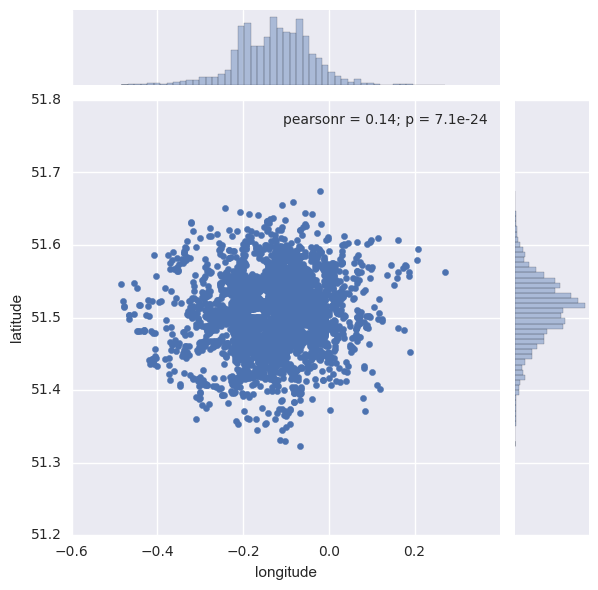

In [38]:
#help(sns.jointplot)
sns.jointplot(x="longitude", y="latitude", data=sample)

You'll notice that this 'map' isn't particularly good, but it does tell us that the longitude and latitude values are reasonable: you'd expect to find more AirBnB listings towards the middle of the city and there's a _hint_ of the Thames and the Lee Valley in there (though this is a bit of a stretch). To actually _map_ the data we'll need to be a little more rigorous... 

Let's step through what's going on below:
1. We need to import the `Point` class so that we move from separate x and y columns to a single 'point' that Geopandas can work with.
2. We then 'zip' up the x and y (i.e. lat and long) into pairs -- think of this as a simple way to pair _each_ x and y based on their row position and this allows us to move from separate columns to actual points.
3. The next step is to tell Geopandas what projection our data is in -- raw lat and long are _usually_ recorded in WGS84 which has the EPSG identifier 4326 (_i.e._ epsg:4326).
4. You'll notice that to create a new `GeoDataFrame` we do so _slightly_ differently from how we created a new `DataFrame` last term: we pass in the existing `pandas` data frame (`sample`), the CRS (projection), and finally the `geometry` that we created from the `zip` process.
5. The last step is to reproject the geometry into OSGB (Ordnance Survey GB) which has the EPSG identifier 27700. 

You can see the results of this step in the final step where we print out the first 3 rows of the reprojected data: notice that the point coordinates are no longer in lat/long!

Some of this _might_ seem a little tedious, but it's incredibly useful to be able to automate this process: we can reproject a whole series of shapefiles (e.g. every single file in a directory!), we can convert CSV files into shapes that load automatically into QGIS instead of having to do this process manually...

In [39]:
from shapely.geometry import Point
# Convert x,y to Points using zip(...)
geometry = [Point(xy) for xy in zip(sample.longitude, sample.latitude)]

print("From the data frame...")
print(sample.head(3)[['longitude','latitude']])
print("-" * 50)

print(" ")
print("From the geometry zip...")
print([", ".join([str(p.x), str(p.y)]) for p in geometry[0:3]])
print("-" * 50)

print(" ")
# Initialise to WGS84
crs = {'init' :'epsg:4326'}
sdf = gpd.GeoDataFrame(sample, crs=crs, geometry=geometry)

# Reproject into OSGB
sdf = sdf.to_crs({'init' :'epsg:27700'})
print(sdf.head(3)[['neighbourhood','geometry']])

# And save it as a new shapefile
sdf.to_file(os.path.join('shapes','AirBnB-Sample.shp'))

From the data frame...
       longitude  latitude
25669         -0        52
30138         -0        52
17293         -0        52
--------------------------------------------------
 
From the geometry zip...
['-0.0454825073598, 51.561290446', '-0.112046580907, 51.5006103339', '-0.140979259842, 51.5588960224']
--------------------------------------------------
 
       neighbourhood                                     geometry
25669  LB of Hackney  POINT (535581.0562142429 186522.1969024616)
30138            NaN  POINT (531141.4366209956 179653.1440572285)
17293      Hampstead  POINT (528968.6631419777 186083.3467175404)


As with the world map above, plotting the AirBnB sample will take some time... so be patient! You'll notice that the results are now also reported in OSGB units, not lat/long, so this is one way in which GeoPandas is more 'knowledgeable' about geodata than pandas.

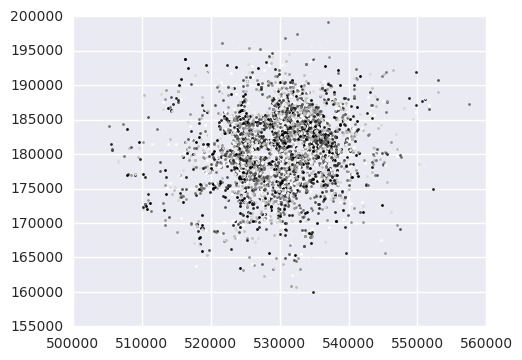

In [40]:
sdf.plot()

#### Saving to a Shapefile!

_Aaaaaand_ as a final step: let's save our data sample as a brand new shape file that we can open directly in QGIS or ArcGIS. This is going to be rather useful: you could create your entire workflow in an automated, replicable fashion, and then just write the results out to a Shapefile so that you can get your visualisation _just right_.

In [42]:
sdf.to_file(os.path.join('data','airbnb','listings.shp'))

## Working with PySAL

Now that we've prepared the raw data, we're ready to begin a more substantive analysis using PySAL. Of course, at this stage we're still going to take it fairly easy and not jump feet-first into using concepts like spatial autocorrelation or spatially-aware statistics.

In [43]:
import os
import pysal as ps
import numpy as np
import seaborn as sns
from pylab import *
from pysal.contrib import pdio
from pysal.contrib.viz import mapping as maps

%matplotlib inline

**_Breaking News!_** Before we get into the guts of PySAL, I wanted to draw your attention to a _brand new_ feature in PySAL 1.13: much tighter integration with/support for pandas. It is now possible to ask PySAL to read a Shapefile or DBF file and return it to you as a pandas dataframe. This expands the range of options for working with geographical data by a significant amount:

```python
table_path = ps.examples.get_path('south.dbf') # Get a sample data set from PySAL
table = ps.pdio.read_files(table_path) # pdio = pandas I/O (input/output)
table.head() # It's a pandas dataframe!
ps.weights.Queen.from_dataframe(table) # Create weights from dataframe
```

You can find out more about the _new_ functions available [here](http://nbviewer.jupyter.org/gist/ljwolf/b960c198742eb26c335d9e32bdc7b76c?flush_cache=true)

### Reading a Shapefile in PySAL

Let's load a shapefile of London LSOAs -- these are the geographical boundaries for the NS-SeC data that you were working with last term. We kept geography out of it since getting to grips with Python is hard work enough, but now we want to begin exploring how adding space to our analysis starts to change _many_ things...

In [44]:
lsoas = ps.open(os.path.join('shapes','LDN-LSOAs.shp'))
print("LSOAs class is: " + str(type(lsoas)))
print("There are " + str(len(lsoas)) + " polygons in the LSOA Shapefile.")
print("Shapefile headers:")
lsoas.header

LSOAs class is: <class 'pysal.core.IOHandlers.pyShpIO.PurePyShpWrapper'>
There are 4835 polygons in the LSOA Shapefile.
Shapefile headers:


{'BBOX Mmax': 0.0,
 'BBOX Mmin': 0.0,
 'BBOX Xmax': 561956.4730099052,
 'BBOX Xmin': 503574.5699225666,
 'BBOX Ymax': 200939.48997558554,
 'BBOX Ymin': 155857.1266921643,
 'BBOX Zmax': 0.0,
 'BBOX Zmin': 0.0,
 'File Code': 9994,
 'File Length': 1423110,
 'Shape Type': 5,
 'Unused0': 0,
 'Unused1': 0,
 'Unused2': 0,
 'Unused3': 0,
 'Unused4': 0,
 'Version': 1000}

In [46]:
listings = ps.open(os.path.join('data','airbnb','listings.shp'))
print("There are " + str(len(listings)) + " points in the listings summary Shapefile.")
listings.header # See what we loaded

There are 4935 points in the listings summary Shapefile.


{'BBOX Mmax': 0.0,
 'BBOX Mmin': 0.0,
 'BBOX Xmax': 557504.7404389234,
 'BBOX Xmin': 505230.66002214886,
 'BBOX Ymax': 199220.60939124995,
 'BBOX Ymin': 159943.10984523015,
 'BBOX Zmax': 0.0,
 'BBOX Zmin': 0.0,
 'File Code': 9994,
 'File Length': 69140,
 'Shape Type': 1,
 'Unused0': 0,
 'Unused1': 0,
 'Unused2': 0,
 'Unused3': 0,
 'Unused4': 0,
 'Version': 1000}

### Revisiting Classification

Like pandas/geopandas, PySAL has a classification 'engine' that we can use to bin data based on attribute values. You might wonder why PySAL has its own process when we can already do this within pandas -- there are two reasons: first, now that we've got a shapefile we don't _really_ need to use pandas/geopandas any more and can do our work solely using PySAL; second, PySAL has additional classification methods that are _specific_ to geographic analysis problems. 

The best-known of these is Fisher-Jenks (also sometimes known as 'Natural Breaks'), which groups data into bins based on the sum of squared deviations between classes: in other words, the algorithm iteratively looks for ways to group the data into a specified number of bins such that moving a data point from one group to another would increase the total within-class deviation observed in the data.

But first, let's just go with quantiles and see how you can now work only with PySAL:

In [48]:
# Notice: listingsdata != listings (DBF != SHP)
listingsdata = ps.open(os.path.join('data','airbnb','listings.dbf'))
print("There are " + str(len(listingsdata)) + " rows in the listings DBF.")
listingsdata.header # See what we loaded

prices = np.array(listingsdata.by_col['price']) # Retrieve pricing data
pricesq5 = ps.esda.mapclassify.Quantiles(prices, k=5) # Classify into 5 quantiles
print(pricesq5) # Show the classification result

There are 4935 rows in the listings DBF.
                  Quantiles                   
 
 Lower              Upper                Count
           x[i] <=   40.000               1177
  40.000 < x[i] <=   60.000                931
  60.000 < x[i] <=   89.000                892
  89.000 < x[i] <=  130.000               1000
 130.000 < x[i] <= 2502.000                935


In [49]:
pricesq5.yb # Check the class assignment

array([1, 3, 1, ..., 0, 1, 0])

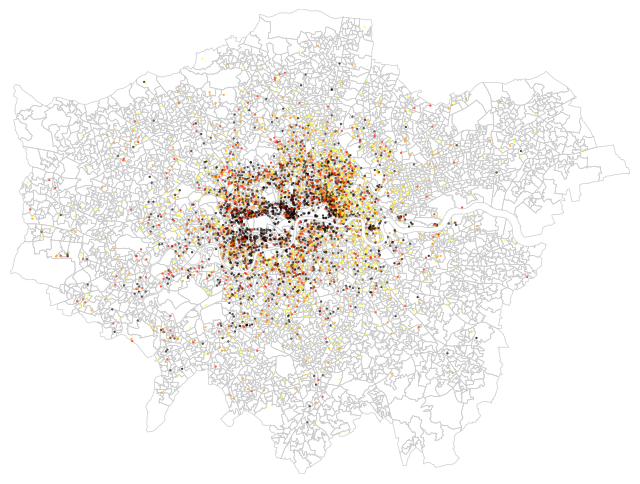

In [50]:
# dir(maps) # If you want to explore this class
# help(maps.map_poly_shp) # And here's how we plot polygons!
fig = figure(figsize=(8,6))

base = maps.map_poly_shp(lsoas)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(lyr, pricesq5.yb)
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(2.5, len(listingsdata)))

ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox])
fig.add_axes(ax)
show()

Let's unpick the steps involved in this process:

First, we create the figure and specify an output size (this was done in 'inches' [as the screen sees them] but you can specify other units as well such as pixels and cm):
```python
fig = figure(figsize=(8,6)) # Set the output size in 'inches'
```

Next, we create a 'base' map that uses the LSOA polygons loaded from the LDN-LSOA Shapefile:
```python
base = maps.map_poly_shp(lsoas) # Create a polygon map from the LSOA object
base.set_facecolor('none')      # Set the colour of the 'face' (i.e. interior of the polygon)
base.set_linewidth(0.5)         # Set the width of the edge
base.set_edgecolor('0.8')       # Set the colour of the edge (this is a light grey)
```

Now we'll create another map, this one containing the AirBnB points loaded from the listings shapefile that we created earlier:
```python
lyr = maps.map_point_shp(listings) # Create a point map from the AirBnB listings object
lyr = maps.base_choropleth_classif(lyr, pricesq5.yb) # Turn this into a choropleth 
lyr.set_alpha(0.5)                 # Set the transparency (a.k.a. alpha) to 50%
lyr.set_linewidth(0.)              # Set the line width around each point to 0
lyr.set_sizes(np.repeat(2.5, len(listingsdata))) # Set the size of the points to 2.5 (points?)
```

The final step is to add both 'layers' to our figure (so, technically, we could have moved the `fig` line down to here, but it's easier to figure out what's going on if we leave it up above):
```python
ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox]) # Add layer _and_ bounding box
fig.add_axes(ax) # Specify the axes
show() # Done!

```
Notice that you have to set up the x and y axes (`setup_ax`) using two parameters: the first array contains the layer objects created using `maps.map_<type>_shp(...)`, and the second contains the bounding boxes (`bbox`) derived as part of that process. **Note:** you *cannot* find the `bbox` on the object created using `maps...`, it is associated with the original object created using PySAL (`ps.open(...)`).

Another example, this time using Fisher-Jenks. Notice how the results look very, very different and how the boundaries between bins have been radically altered but also capture a bit better our intuition as to how the data can be represented.

In [51]:
prices = np.array(listingsdata.by_col['price']) # Retrieve pricing data
pricesjk = ps.esda.mapclassify.Fisher_Jenks(prices, k=5) # Classify into 5 quantiles
print(pricesjk) # Show the classification result

                 Fisher_Jenks                 
 
 Lower              Upper                Count
           x[i] <=   83.000               2833
  83.000 < x[i] <=  182.000               1628
 182.000 < x[i] <=  370.000                391
 370.000 < x[i] <= 1001.000                 72
1001.000 < x[i] <= 2502.000                 11


To make it easier to see what's happening in Central London why don't we try zooming in a little bit? Notice that in the previous example we passed in the _bounding box_ as part of the axes command. Have a look at how the `listings.bbox` is set up and see if you can't figure out how to zoom in to something like:

Dimension | Max/Min | Value 
--------- | ------- | -----
Northing | Max | 190000
Northing | Min | 170000
Easting | Max | 540000
Easting | Min | 520000

In [52]:
print(listings.bbox)

[505230.66002214886, 159943.10984523015, 557504.7404389234, 199220.60939124995]


In [53]:
my_bbox = [520000, 170000, 540000, 190000]

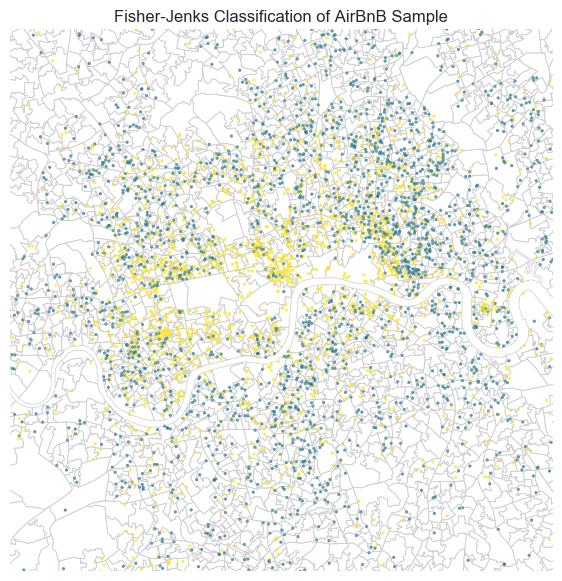

In [56]:
# To find out more about setting colours:
# help(plt.cm)
# help(maps.base_choropleth_classif)

fig = figure(figsize=(7,7)) # Why do you think I changed the figure size this way?

base = maps.map_poly_shp(lsoas)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(lyr, pricesjk.yb, cmap='viridis')
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(5, len(listingsdata))) # Sice of the dots

plt.title("Fisher-Jenks Classification of AirBnB Sample")
ax = maps.setup_ax([base, lyr], [my_bbox, my_bbox]) # You should get a 'crop' of London
fig.add_axes(ax)
show()

We can also look at how the Fisher-Jenks classification relates to the underlying distribution by plotting the prices and bin boundaries derived by PySAL:

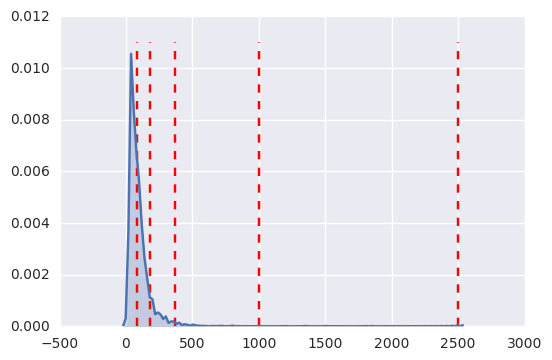

In [57]:
sns.kdeplot(prices, shade=True)
for b in pricesjk.bins:
    plt.vlines(b, 0, 0.011, color='red', linestyle='--')

## Testing Your Understanding

Over to you! I'd like you to test [a number of the `mapclassify` options](http://pysal.readthedocs.io/en/latest/library/esda/mapclassify.html) and make up your own mind as to which is the 'best' for classifying the AirBnB data for London. To do this you will need to think about how you can automate the steps we've taken above, including:

* Loading the data
* Running the classifer
* Outputting it to a map
* Outputting the distribution with bin boundaries
* Looking at 'goodness-of-fit' metrics (see the documentation)

To make sure that you've done all of this correctly you should be able to click on 'Kernel' > 'Restart' and then run _only_ the code in the block below fully and successfully. So you'll need to factor in things like loading the libraries that you'll need, telling the notebook where to find the data, etc.

In [ ]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import pysal as ps
import numpy as np
from pylab import *
from pysal.contrib import pdio
from pysal.contrib.viz import mapping as maps

import random 
random.seed(123456789) # For reproducibility

%matplotlib inline

df = pd.read_csv(os.path.join('data','airbnb','listings.csv.gz'))

print("Full data set shape is: " + ' by '.join(str(i) for i in df.shape))

df['price'] = pd.to_numeric(df.price.str.replace('$','').str.replace(',',''))

print("Fixed pricing data...")

from shapely.geometry import Point
# Convert x,y to Points using zip(...)
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]

# Initialise to WGS84
crs = {'init' :'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Reproject into OSGB
gdf = gdf.to_crs({'init' :'epsg:27700'})
print(gdf.sample(4)[['neighbourhood','geometry']])

print("GeoPandas data frame created...")

# And save it as a new shapefile
gdf.to_file(os.path.join('shapes','AirBnB-Full.shp'))

print("Saved new shapefile from geopandas df...")

In [5]:
print("Loading data for PySAL")

listingsdata = ps.open(os.path.join('shapes','AirBnB-Full.dbf'))
lsoas        = ps.open(os.path.join('shapes','LDN-LSOAs.shp'))
listings     = ps.open(os.path.join('shapes','AirBnB-Full.shp'))

Loading data for PySAL


Classifying data...
                 Natural_Breaks                
 
 Lower              Upper                 Count
           x[i] <=   45.000               14287
  45.000 < x[i] <=   78.000               12292
  78.000 < x[i] <=  130.000               13238
 130.000 < x[i] <=  230.000                6730
 230.000 < x[i] <=  520.000                2512
 520.000 < x[i] <= 2502.000                 270
2502.000 < x[i] <= 8006.000                  19


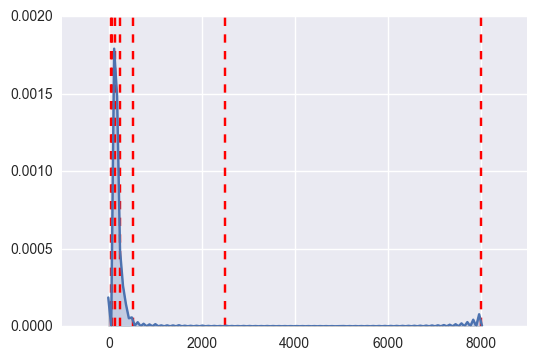

In [12]:
print("Classifying data...")

prices = np.array(listingsdata.by_col['price']) # Retrieve pricing data

prices_cl = ps.esda.mapclassify.Natural_Breaks(prices, k=7) # Classify 
print(prices_cl) # Show the classification result

kd = sns.kdeplot(prices, shade=True)
ax = kd.axes
kd
#print(ax[0,0].get_ylim())
for b in prices_cl.bins:
    plt.vlines(b, 0, 0.002, color='red', linestyle='--')

Creating map


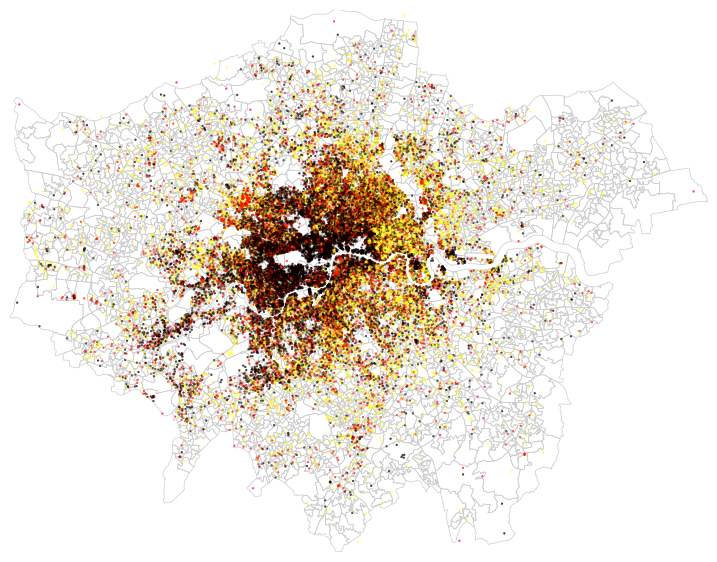

In [13]:
print("Creating map")

fig = figure(figsize=(9,7))

base = maps.map_poly_shp(lsoas)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(lyr, prices_cl.yb)
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(2.5, len(listingsdata)))

ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox])
fig.add_axes(ax)
show()

Classifying logged data...
             Natural_Breaks             
 
Lower          Upper               Count
        x[i] <= 3.332               3524
3.332 < x[i] <= 3.738               8723
3.738 < x[i] <= 4.111               9161
4.111 < x[i] <= 4.443               8062
4.443 < x[i] <= 4.820               8972
4.820 < x[i] <= 5.412               7886
5.412 < x[i] <= 8.988               3020


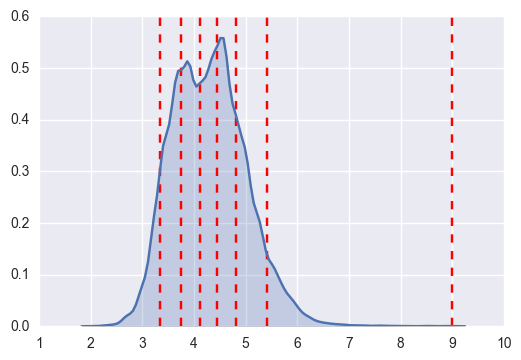

In [16]:
print("Classifying logged data...")

prices = np.log(np.array(listingsdata.by_col['price'])) # Retrieve pricing data

prices_cl = ps.esda.mapclassify.Natural_Breaks(prices, k=7) # Classify 
print(prices_cl) # Show the classification result

kd = sns.kdeplot(prices, shade=True)
ax = kd.axes
kd
#print(ax[0,0].get_ylim())
for b in prices_cl.bins:
    plt.vlines(b, 0, 0.6, color='red', linestyle='--')

Creating map


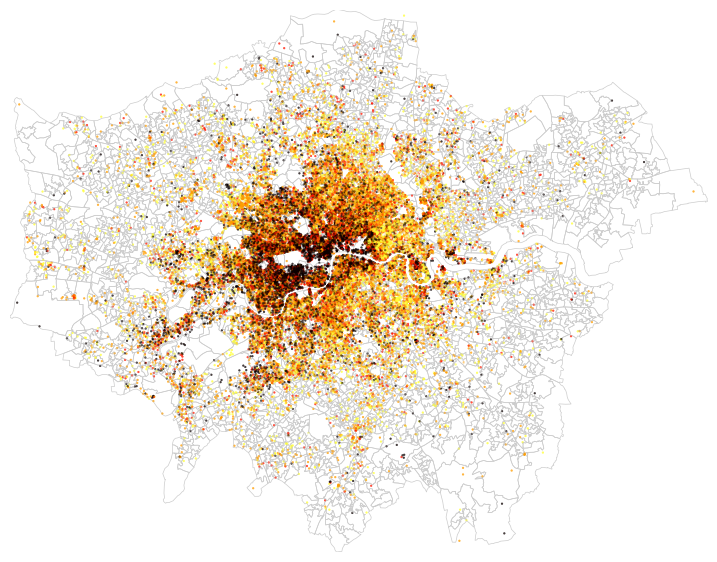

In [17]:
print("Creating map")

fig = figure(figsize=(9,7))

base = maps.map_poly_shp(lsoas)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(lyr, prices_cl.yb)
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(2.5, len(listingsdata)))

ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox])
fig.add_axes(ax)
show()